# Notebook 03a | Exploração Inicial do Dados

Objetivos:

- Explorar visualmente a série mensal agregada de total_sales_usd de todas as lojas  
- Identificar estatísticas descritivas, outliers e dispersão (boxplot)  
- Visualizar a série temporal (linha)  
- Analisar sazonalidade anual (decomposição)  

## 1. Configuração do Ambiente

Importar bibliotecas e definir caminho dos dados mensais.


In [0]:
# Inicializar Spark e importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

spark = SparkSession.builder.getOrCreate()

# Caminho do Parquet mensal no DBFS
gold_monthly_parquet = "/FileStore/gold/sales_monthly_gold"

## 2. Carregamento dos Dados Mensais

Ler o Parquet com Spark e converter para pandas para análise.


In [0]:
# Carregar Parquet via Spark e garantir tipo date
df_spark = (
    spark.read
         .format("parquet")
         .load(gold_monthly_parquet)
    .withColumn("month_start", to_date("month_start"))
)

# Converter para pandas para visualizações
df = df_spark.toPandas()

# Garantir que a coluna esteja em datetime no pandas
df['month_start'] = pd.to_datetime(df['month_start'])

## 3. Boxplot de Vendas Mensais

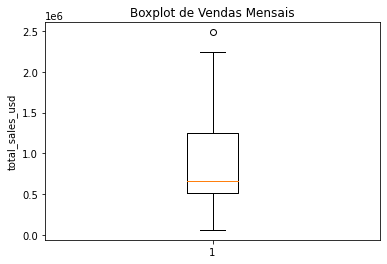

In [0]:
# Gerar boxplot de total_sales_usd
plt.figure(figsize=(6,4))
plt.boxplot(df['total_sales_usd'].astype(float), vert=True)
plt.title('Boxplot de Vendas Mensais')
plt.ylabel('total_sales_usd')
plt.show()

## 4. Série Temporal Mensal

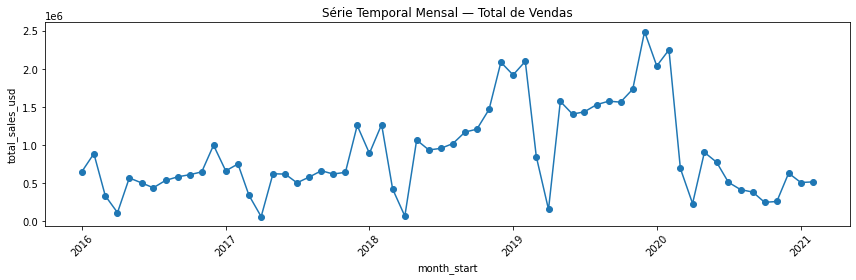

In [0]:
# Gerar série temporal de total_sales_usd
plt.figure(figsize=(12,4))
plt.plot(df['month_start'], df['total_sales_usd'].astype(float), marker='o', linestyle='-')
plt.title('Série Temporal Mensal — Total de Vendas')
plt.xlabel('month_start')
plt.ylabel('total_sales_usd')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Estatísticas Descritivas

In [0]:
# Exibir estatísticas descritivas de total_sales_usd
print(df['total_sales_usd'].describe())

count    6.200000e+01
mean     8.927333e+05
std      5.830034e+05
min      5.915818e+04
25%      5.077013e+05
50%      6.606503e+05
75%      1.243197e+06
max      2.486563e+06
Name: total_sales_usd, dtype: float64


## 6. Análise de Sazonalidade

### 6.1 Decomposição STL


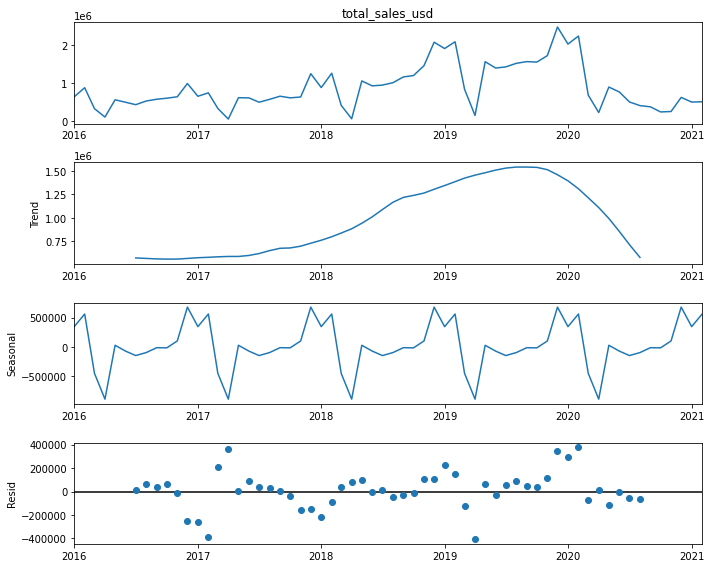

In [0]:
# Decomposição aditiva da série temporal com STL
series = df.set_index('month_start')['total_sales_usd']
decomp = seasonal_decompose(series, model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.tight_layout()
plt.show()

### 6.2 Sazonalidade por Mês do Ano


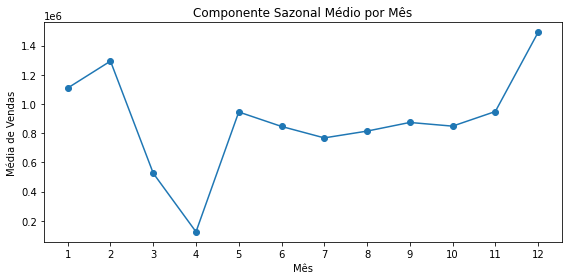

In [0]:
# Cálculo e plot da média mensal de vendas para sazonalidade
df['month'] = df['month_start'].dt.month
seasonal = df.groupby('month')['total_sales_usd'].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(seasonal['month'], seasonal['total_sales_usd'], marker='o', linestyle='-')
plt.title('Componente Sazonal Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Média de Vendas')
plt.xticks(seasonal['month'])
plt.tight_layout()
plt.show()


## 7. Conclusões das Análises e Próximos Passos

### 7.1 Conclusões
A análise visual dos dados permitiu identificar que:
- Existe uma sazonalidade bem definida nas vendas.
- A pandemia de Covid-19 impactou diretamente o volume de vendas de eletrodomésticos.
- Será necessária a correção de outliers nos resíduos para aprimorar o desempenho dos modelos preditivos.

### 7.2 Próximos Passos
Dado o comportamento sazonal identificado, serão utilizados os modelos SARIMA e Prophet para determinar qual apresenta melhor performance.

Como os dados disponíveis vão apenas até fevereiro de 2021, não é possível realizar uma validação em período totalmente pós-pandemia. Para contornar essa limitação, será adotada uma abordagem de análise com dois blocos temporais distintos:

- **Primeiro bloco:**  
  - Treinamento: 2016 a 2018  
  - Teste: 2019 (período normal, pré-pandemia)

- **Segundo bloco:**  
  - Treinamento: 2016 a 2019  
  - Teste: 2020 até fevereiro de 2021 (período afetado pela pandemia)

Essa estratégia permitirá validar o modelo em condições normais, avaliar seu desempenho durante a pandemia e projetar uma trajetória alternativa de faturamento caso a pandemia não tivesse ocorrido.
